# Projection 2025 HRs with Hiearchical Modeling

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm

In [9]:
import sys
sys.path.append('..')
from src.processing import load_data, create_panel_data_for_modeling, get_player_career_stats
from src.modeling import run_hierarchical_model, simulate_season

In [10]:
sns.set_style("whitegrid")

In [11]:
df = load_data(filepath='../data/raw/fangraphs-leaderboards.csv')

In [12]:
df = df[df['PA'] >= 250]
df_panel = create_panel_data_for_modeling(df, start_year=2015, end_year=2024)
cal_historical_stats = get_player_career_stats(df, 'Cal Raleigh', end_year=2024)
print("--- Cal Raleigh's Historical Stats (2022-2024) for Projection ---")
print(f"ISO: {cal_historical_stats['ISO']:.3f}, Barrel%: {cal_historical_stats['Barrel%']:.2f}, HardHit%: {cal_historical_stats['HardHit%']:.2f}")
print(f"SLG: {cal_historical_stats['SLG']:.3f}, Med%: {cal_historical_stats['Med%']:.2f}, BB%: {cal_historical_stats['BB%']:.2f}, Age: {cal_historical_stats['Age']:.0f}")

--- Cal Raleigh's Historical Stats (2022-2024) for Projection ---
ISO: 0.220, Barrel%: 0.14, HardHit%: 0.45
SLG: 0.446, Med%: 0.44, BB%: 0.10, Age: 27


# Approach 1: Base Model (ISO, Barrel%, HardHit%)

In [13]:
print("\n--- Running Hierarchical Model 1 (Base Model) ---")
base_features = ['ISO_lag1', 'Barrel%_lag1', 'HardHit%_lag1']
modeling_df_base = df_panel.dropna(subset=base_features)
idata_base = run_hierarchical_model(modeling_df_base, base_features)

# Project Cal Raleigh's 2025 Season
cal_features_base = np.array([cal_historical_stats['ISO'], cal_historical_stats['Barrel%'], cal_historical_stats['HardHit%']])
estimated_total_pa = 700

# Reshape betas_post into a 2D array (total_samples x num_features)
posterior_samples = idata_base.posterior
mu_alpha_post = posterior_samples['mu_alpha'].values.flatten()
betas_post = posterior_samples['betas'].values.reshape(-1, len(base_features))

cal_logits_projected = mu_alpha_post + np.dot(betas_post, cal_features_base)
cal_hr_rates_projected = 1 / (1 + np.exp(-cal_logits_projected))

simulated_hrs_base = np.random.binomial(estimated_total_pa, cal_hr_rates_projected, size=len(cal_hr_rates_projected))



--- Running Hierarchical Model 1 (Base Model) ---


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_alpha, sigma_alpha, betas, alpha]


/home/abarel/virtualenvs/mcmc-baseball/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


# Approach 2: Expanded Model (Additional features)

Initializing NUTS using jitter+adapt_diag...



--- Running Hierarchical Model 2 (Expanded Model) ---


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_alpha, sigma_alpha, betas, alpha]


/home/abarel/virtualenvs/mcmc-baseball/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


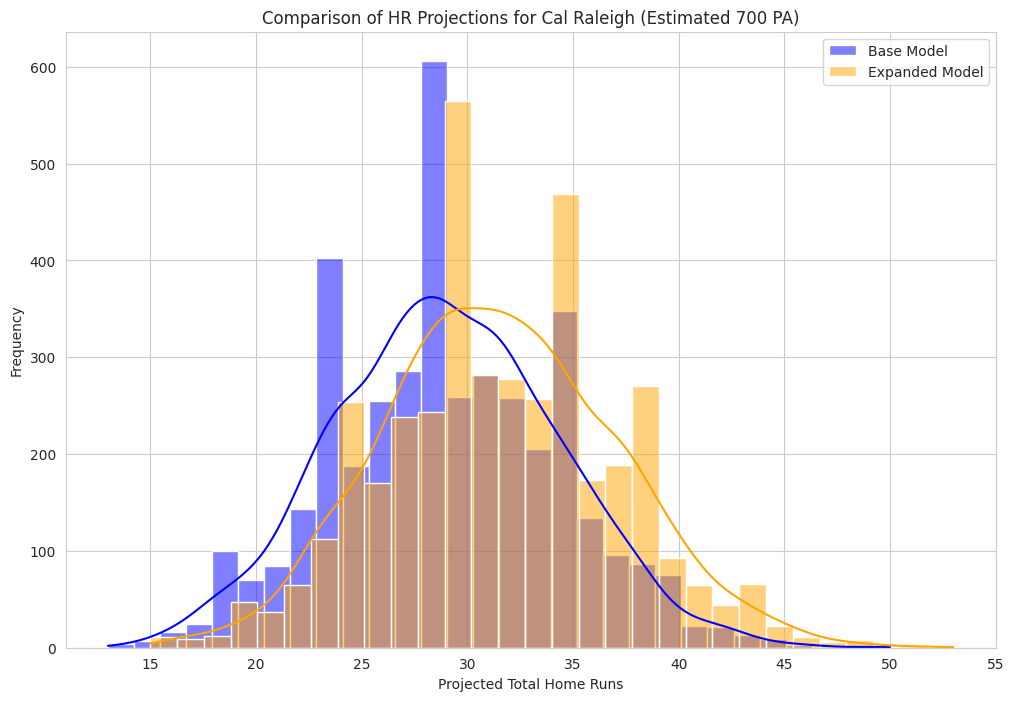


--- Comparison of Results ---
Base Model (ISO, Barrel%, HardHit%):
  Mean Projected HRs: 28.99
  Median Projected HRs: 29.00
  95% CI: [19, 39]

Expanded Model (with SLG, Med%, BB%, Age):
  Mean Projected HRs: 31.53
  Median Projected HRs: 31.00
  95% CI: [21, 43]


In [14]:
print("\n--- Running Hierarchical Model 2 (Expanded Model) ---")
expanded_features = ['ISO_lag1', 'Barrel%_lag1', 'HardHit%_lag1', 'SLG_lag1', 'Med%_lag1', 'BB%_lag1', 'Age_lag1']

modeling_df_expanded = df_panel.dropna(subset=expanded_features)
idata_expanded = run_hierarchical_model(modeling_df_expanded, expanded_features)

# Project Cal Raleigh's 2025 Season with the expanded model
cal_features_expanded = np.array([cal_historical_stats['ISO'], cal_historical_stats['Barrel%'], cal_historical_stats['HardHit%'], 
                                   cal_historical_stats['SLG'], cal_historical_stats['Med%'], cal_historical_stats['BB%'], cal_historical_stats['Age']])

# Reshape betas_post into a 2D array
posterior_samples_expanded = idata_expanded.posterior
mu_alpha_post_expanded = posterior_samples_expanded['mu_alpha'].values.flatten()
betas_post_expanded = posterior_samples_expanded['betas'].values.reshape(-1, len(expanded_features))

cal_logits_projected_expanded = mu_alpha_post_expanded + np.dot(betas_post_expanded, cal_features_expanded)
cal_hr_rates_projected_expanded = 1 / (1 + np.exp(-cal_logits_projected_expanded))

simulated_hrs_expanded = np.random.binomial(estimated_total_pa, cal_hr_rates_projected_expanded, size=len(cal_hr_rates_projected_expanded))
# 5. Results and Comparison
plt.figure(figsize=(12, 8))
sns.histplot(simulated_hrs_base, kde=True, bins=30, color='blue', label='Base Model')
sns.histplot(simulated_hrs_expanded, kde=True, bins=30, color='orange', label='Expanded Model')
plt.title(f'Comparison of HR Projections for Cal Raleigh (Estimated {estimated_total_pa} PA)')
plt.xlabel('Projected Total Home Runs')
plt.ylabel('Frequency')
plt.legend()
plt.show()

print("\n--- Comparison of Results ---")
print("Base Model (ISO, Barrel%, HardHit%):")
print(f"  Mean Projected HRs: {np.mean(simulated_hrs_base):.2f}")
print(f"  Median Projected HRs: {np.median(simulated_hrs_base):.2f}")
print(f"  95% CI: [{np.percentile(simulated_hrs_base, 2.5):.0f}, {np.percentile(simulated_hrs_base, 97.5):.0f}]")
print("\nExpanded Model (with SLG, Med%, BB%, Age):")
print(f"  Mean Projected HRs: {np.mean(simulated_hrs_expanded):.2f}")
print(f"  Median Projected HRs: {np.median(simulated_hrs_expanded):.2f}")
print(f"  95% CI: [{np.percentile(simulated_hrs_expanded, 2.5):.0f}, {np.percentile(simulated_hrs_expanded, 97.5):.0f}]")